<a href="https://colab.research.google.com/github/mariameneses/prediccion-precios-casas/blob/main/RF_Precios_Casas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de precios de casas usando modelo de bosque aleatorio (Random Forest, RF)

### 1. Añadir los archivos de datos a Colab

- Ingresar a la sección de "Archivos" del panel izquierdo de colab

- Arrastar los archivos "train.py" y "test.py" a la sección de "Archivos"

### 2. Instalar e importar la librerías requeridas

- Instalar la librería "tensorflow-decision-forests"

In [1]:
!pip install tensorflow-decision-forests --quiet

- Importar las librerías requeridas

In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

%matplotlib inline

print("--- Librerías importadas ---")
print("Versión de TensorFlow: v" + tf.__version__)
print("Versión de TensorFlow Decision Forest: v" +  tfdf.__version__)

--- Librerías importadas ---
Versión de TensorFlow: v2.12.0
Versión de TensorFlow Decision Forest: v1.3.0


### 3. Cargar y analizar el conjunto de datos a usar

- Cargar conjunto de datos de entrenamiento

In [3]:
# Datos de entrenamiento
train_file_path = "/content/train.csv"
train_df = pd.read_csv(train_file_path)
print("\n-- Conjunto de entrenamiento --")
print(f"Contiene {train_df.shape[0]} elementos con {train_df.shape[1]} características\n")
print(train_df.head(3))


-- Conjunto de entrenamiento --
Contiene 1460 elementos con 81 características

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  

[3 rows x 81 columns]


- Procesar conjunto de datos

In [4]:
train_df = train_df.drop('Id', axis=1)

- Se observa la distribución de los precios de las casas del conjunto de entrenamiento

Descripción de los precios de las casas del conjunto de entrenamiento:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


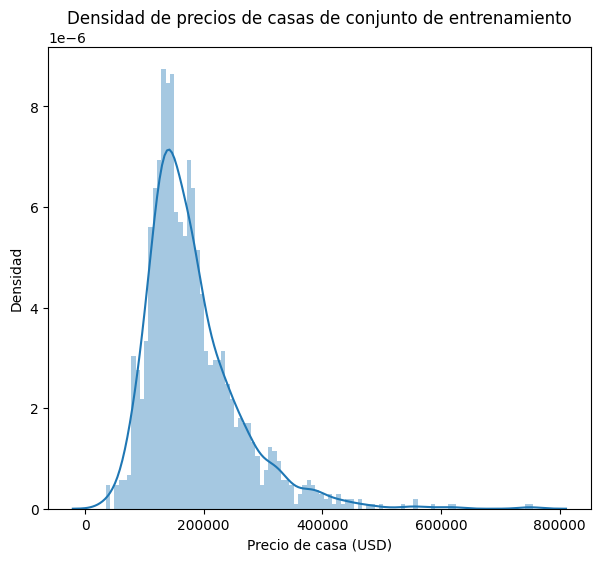

In [5]:
print("Descripción de los precios de las casas del conjunto de entrenamiento:")
print(train_df['SalePrice'].describe())

plt.figure(figsize=(7,6))
sns.histplot(
  train_df['SalePrice'], kde=True, stat="density", kde_kws=dict(cut=3),
  bins=100, alpha=.4, edgecolor=None
)
plt.title("Densidad de precios de casas de conjunto de entrenamiento")
plt.ylabel("Densidad")
plt.xlabel("Precio de casa (USD)")
plt.show()

- Se selecciona las características numéricas para observar su distribución en el conjunto de entrenamiento

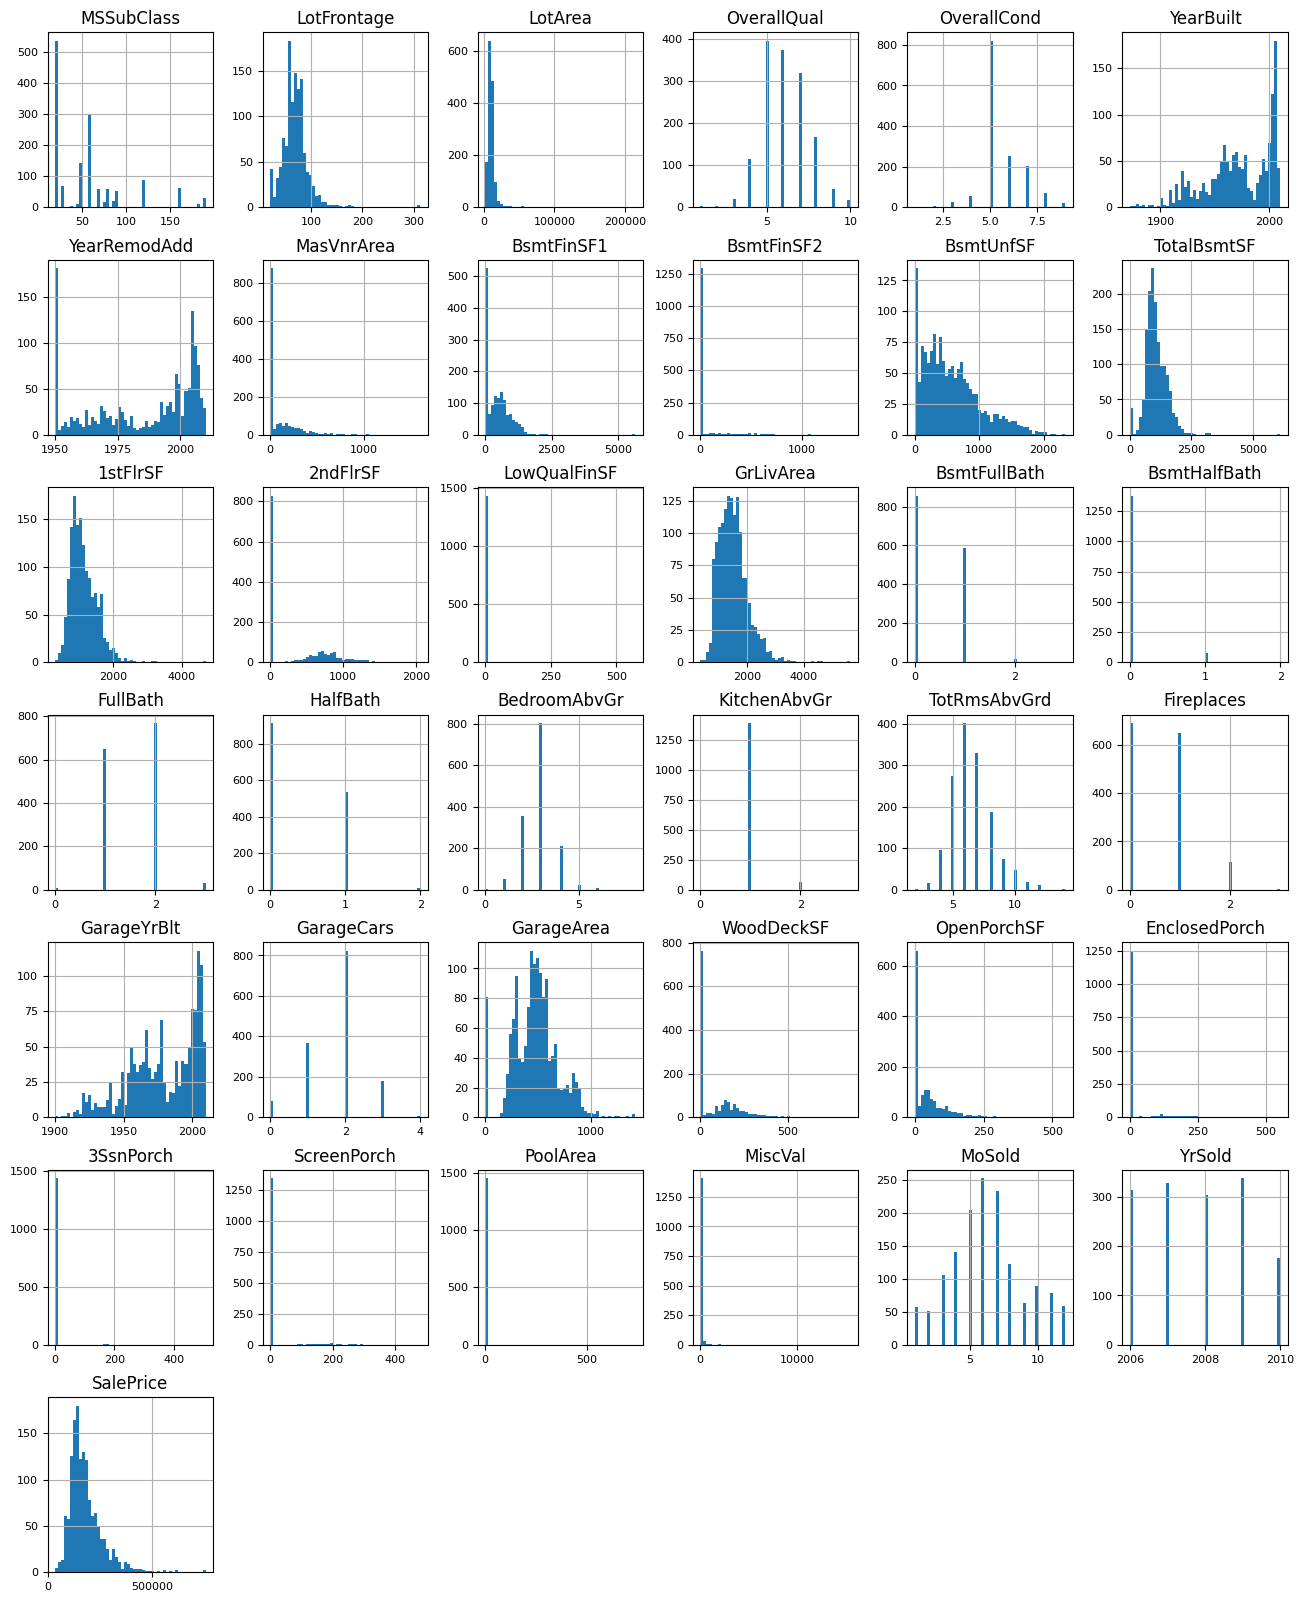

In [6]:
num_train_df = train_df.select_dtypes(include=['float64', 'int64'])
num_train_df.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

- Dividir los datos de entrenamiento en conjunto de entrenamiento y validación

In [7]:
def split_dataset(dataset, train_percentage, random_seed):
  data_shuffle = dataset.sample(frac=1, random_state=random_seed)
  amount_train = int(len(dataset)*train_percentage/100)
  train, validate = np.split(data_shuffle, [amount_train])

  return train, validate

train_ds, valid_ds = split_dataset(train_df, 80, 15)
print(f"Total datos de entrenamiento: {len(train_ds)}")
print(f"Total datos de validación: {len(valid_ds)}")

Total datos de entrenamiento: 1168
Total datos de validación: 292


- Se convierte los conjuntos de datos de DataFrame a Dataset de TensorFLow

In [8]:
label = 'SalePrice'
train = tfdf.keras.pd_dataframe_to_tf_dataset(
  train_ds, label=label, task=tfdf.keras.Task.REGRESSION
)
valid = tfdf.keras.pd_dataframe_to_tf_dataset(
  valid_ds, label=label, task=tfdf.keras.Task.REGRESSION
) 

### 4. Implementación del modelo de Bosque Aleatorio (RF)

- Se define modelo de Bosque Aleatorio (RF) y métrica MSE

In [9]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpzlqvuj_3 as temporary training directory


- Se entrena el modelo con los datos de entrenamiento

In [10]:
rf.fit(x=train)

Reading training dataset...
Training dataset read in 0:00:10.481375. Found 1168 examples.
Training model...
Model trained in 0:00:19.597801
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


- Se calcula y grafica el RMSE para el conjunto de datos out-of-bag (OOB)

Resultados de evaluación en OOB: Evaluation(num_examples=1168, accuracy=None, loss=None, rmse=29614.35056479347, ndcg=None, aucs=None, auuc=None, qini=None) 



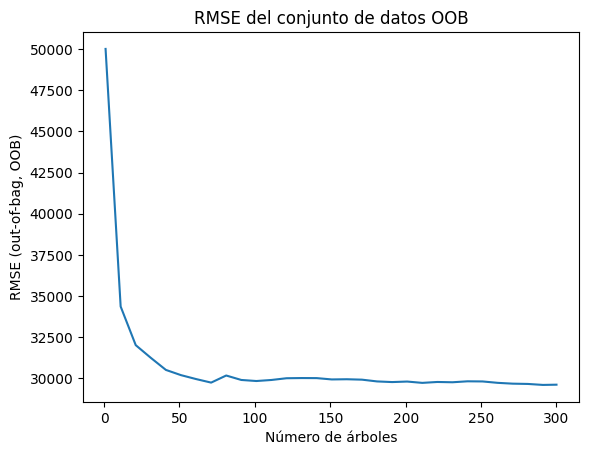

In [11]:
eval = rf.make_inspector().evaluation()
print(f"Resultados de evaluación en OOB: {eval} \n")

logs = rf.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.title("RMSE del conjunto de datos OOB")
plt.xlabel("Número de árboles")
plt.ylabel("RMSE (out-of-bag, OOB)")
plt.show()

### 5. Evaluación del modelo RF en el conjunto de validación

- Se obtiene el MSE al evaluar las predicciones con conjunto de validación

In [12]:
evaluation = rf.evaluate(x=valid, return_dict=True)

print(f"\nMSE: {evaluation['mse']}")

1/1 [==============================] - 1s 619ms/step - loss: 0.0000e+00 - mse: 894720896.0000

MSE: 894720896.0


### 6. Gráfica de características importantes

- Se grafica las caracterísiticas importantes para la importancia variable "NUM_AS_ROOT"

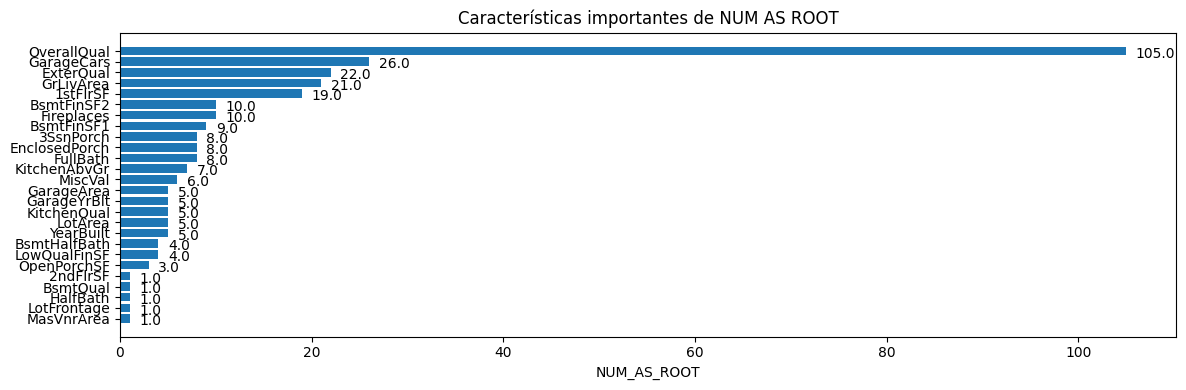

In [13]:
var_import = rf.make_inspector().variable_importances()

plt.figure(figsize=(12,4))

variable_importance_metric = "NUM_AS_ROOT"
variable_importances = var_import[variable_importance_metric]


feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]

feature_ranks = range(len(feature_names))

bar = plt.barh(
  feature_ranks, feature_importances, label=[str(x) for x in feature_ranks]
)
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

for importance, patch in zip(feature_importances, bar.patches):
  plt.text(
    patch.get_x() + patch.get_width() + 1, patch.get_y(),
    f"{importance:.1f}", va="top"
  )

plt.xlabel(variable_importance_metric)
plt.title("Características importantes de NUM AS ROOT")
plt.tight_layout()
plt.show()

### 7. Aplicación del modelo en el conjunto de datos de prueba

- Se carga el conjunto de datos de prueba

In [15]:
# Datos de prueba
test_file_path = "/content/test.csv"
test_df = pd.read_csv(test_file_path)
print("\n-- Conjunto de prueba --\n")
print(f"Contiene {test_df.shape[0]} elementos con {test_df.shape[1]} características")

ids = test_df.pop('Id')

test = tfdf.keras.pd_dataframe_to_tf_dataset(
  test_df, task = tfdf.keras.Task.REGRESSION
)


-- Conjunto de prueba --

Contiene 1459 elementos con 80 características


- Se predice los precios de las casas para los datos de prueba

In [16]:
preds = rf.predict(test)

output = pd.DataFrame({'Id': ids, 'SalePrice': preds.squeeze()})

print("\nResultados de predicción con conjunto de datos de prueba\n")
print(output.head(3))

2/2 [==============================] - 1s 40ms/step

Resultados de predicción con conjunto de datos de prueba

     Id     SalePrice
0  1461  124998.40625
1  1462  154065.59375
2  1463  180481.40625


### 8. Participar en la competencia

- Se genera el archivo para la competencia

In [17]:
output.to_csv("/content/submission.csv", index=False)

- Dirigirse al panel izquierdo y descargar el archivo "submission.csv"
- Se carga el archivo en la opción "Submit Predictions" de Kaggle